In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir

import os

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

In [2]:
config_path = f"config_MN_ageihrs.yml"
run_id = "config_MN_ageihrs"

config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = "emcee"

out_prefix = in_prefix

write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_MN_ageihrs.yml


In [3]:
# find what to perturb
fitted_params = {
    "ptype":[],
    "pname":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
ndim=0

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("snpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("hnpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)

SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj_age0to11m has perturbation, recording
 >> IHRadj_age1to4 has perturbation, recording
 >> IHRadj_age5to17 has perturbation, recording
 >> IHRadj_age18to49 has perturbation, recording
 >> IHRadj_age50to64 has perturbation, recording
 >> IHRadj_age65to100 has perturbation, recording


In [4]:
# Find the ground-truth
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

## Create the first gempyor object

In [5]:

print("MAKING A TEST RUN TO GET SETUP")
(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.get_from_config(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.get_from_config(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

outcomes_df_ref = outcomes_df_ref.set_index("date")
print("TEST RUN IS DONE")

MAKING A TEST RUN TO GET SETUP


INFO:root:[SEIR.compartments] completed in 4.34 s
CRITICAL:root:No delay for outcome incidH_age0to11m_v2, using a 0 delay
CRITICAL:root:No delay for outcome incidH_age1to4_v2, using a 0 delay
CRITICAL:root:No delay for outcome incidH_age5to17_v2, using a 0 delay
CRITICAL:root:No delay for outcome incidH_age18to49_v2, using a 0 delay
CRITICAL:root:No delay for outcome incidH_age50to64_v2, using a 0 delay
CRITICAL:root:No delay for outcome incidH_age65to100_v2, using a 0 delay
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
3653it [00:12, 289.98it/s]


TEST RUN IS DONE


In [6]:
import xarray as xr

In [7]:
p_draw.shape

(92, 7306, 1)

In [8]:
modinf.subpop_pop

array([5639632])

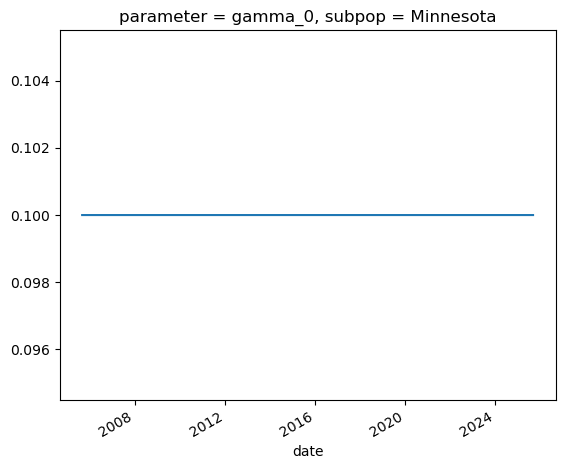

In [9]:
xr.DataArray(p_draw, dims=["parameter", "date", "subpop"],  
                coords={"parameter":modinf.parameters.pnames, 
                "date":pd.date_range(modinf.ti, modinf.tf, freq="D"), 
                "subpop":modinf.subpop_struct.subpop_names}).sel(parameter="gamma_0").plot()

In [10]:
# need to convert to numba dict to python dict so it is pickable
seeding_data = dict(seeding_data)

In [11]:
if False:
    outcomes_df = run_simulation(snpi_df_in=snpi_df_ref, hnpi_df_in=hnpi_df_ref)
    outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
    outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [12]:
#proposal = np.random.random(size=ndim)
#print(log_prob(proposal))
#proposal = np.random.random(size=ndim)*2
#print(log_prob(proposal))

In [13]:
nwalkers = 32
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:,i] = fitted_params["pdist"][i](nwalkers)

In [14]:
#print(fitted_params["lb"])
#print(p0)
#print(fitted_params["ub"])

In [15]:
subpop="Minnesota"
gt_s = gt[gt["subpop"]==subpop]
gt_s.sort_index()

subpop  incidH_0_0.99  incidH_18_49  incidH_1_4  incidH_50_64  \
date                                                                           
2008-10-11  Minnesota            NaN           0.0         NaN           0.0   
2008-10-18  Minnesota            NaN           3.0         NaN           0.0   
2008-10-25  Minnesota            NaN           0.0         NaN           0.0   
2008-11-01  Minnesota            NaN           0.0         NaN           0.0   
2008-11-08  Minnesota            NaN           0.0         NaN           3.0   
...               ...            ...           ...         ...           ...   
2024-01-13  Minnesota           78.0          12.0        46.0          12.0   
2024-01-20  Minnesota           74.0          10.0        22.0          12.0   
2024-01-27  Minnesota           52.0           3.0        22.0           9.0   
2024-02-03  Minnesota           41.0           7.0         6.0          17.0   
2024-02-10  Minnesota           30.0           0.0        12.0           8.0   

            incidH_5_17  incidH_65_100  
date                                    
2008-10-11          NaN            0.0  
2008-10-18          NaN            0.0  
2008-10-25          NaN            0.0  
2008-11-01          NaN            0.0  
2008-11-08          NaN            0.0  
...                 ...            ...  
2024-01-13          6.0           43.0  
2024-01-20          0.0           50.0  
2024-01-27          2.0           35.0  
2024-02-03          2.0           39.0  
2024-02-10          2.0           26.0  

[547 rows x 7 columns]

In [16]:
import emcee

from multiprocessing import Pool
from gempyor_logprob import log_prob, compute_likelyhood, check_in_bounds, run_simulation, input_proposal



print(f"initial llik {compute_likelyhood(outcomes_df_ref, gt, modinf, statistics)}")


incidH_age0to11m (801,) (801,)
incidH_age1to4 (801,) (801,)
incidH_age5to17 (801,) (801,)
incidH_age18to49 (801,) (801,)
incidH_age50to64 (801,) (801,)
incidH_age65to100 (801,) (801,)
initial llik -2469978.2789704045


In [17]:
fitted_params

{'ptype': ['snpi',
  'snpi',
  'snpi',
  'snpi',
  'snpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi',
  'hnpi'],
 'pname': ['Ro_mod',
  'covid_mod',
  'omicron_mod',
  'seas_amp_mod',
  'seas_offset_mod',
  'IHRadj_age0to11m',
  'IHRadj_age1to4',
  'IHRadj_age5to17',
  'IHRadj_age18to49',
  'IHRadj_age50to64',
  'IHRadj_age65to100'],
 'pdist': [<bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x300310c50>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x300310d90>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x300310050>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x30032c490>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x30032eb10>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continu

In [18]:
for i in range(nwalkers):
    assert check_in_bounds(p0[i], fitted_params)

In [19]:
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters], 
                                    pool=pool,
                                    backend=backend)
    state = sampler.run_mcmc(p0, 10, progress=True)

INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.03 s
INFO:roo

emcee: Exception while calling your likelihood function:
  params: [ 1.12493065  0.09328713  0.30159318  0.34611349 -0.04739552  0.56353804
  0.72913818  0.54092991  0.64654892  0.73654337  0.53887087]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [1.16784554 0.40283002 0.70876735 0.03803258 0.15041377 0.5884241
 0.77562443 0.68990678 0.801898   0.68359698 0.67207056]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod',

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.99011335  0.48341951  0.43577281  0.35320448 -0.13451757  0.70486638
  0.87965823  0.61112145  0.74638855  0.62201424  0.73657756]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 1.05644793  0.43772323  0.63218893  0.4608475  -0.17997841  0.79839699
  0.78608831  0.49430865  0.7505442   0.82439252  0.70244585]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [1.16342902 0.28746731 0.46834511 0.3799982  0.02364647 0.7416778
 0.82276058 0.74354964 0.60086106 0.61821211 0.76958691]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod',

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [0.93312627 0.3432003  0.37308794 0.27228854 0.08882763 0.68157469
 0.76819044 0.9655253  0.66467611 1.00752897 0.76871512]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 1.1277454   0.34850739  0.47565097  0.30253746 -0.08084377  0.64653542
  0.61892118  0.71349335  0.72366117  0.6166963   0.75185008]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 1.05757056  0.64832409  0.45537825  0.17622578 -0.11503916  0.79937919
  0.63139429  0.77814617  0.38321039  0.83515721  0.67702565]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.9931916   0.45038515  0.25659076  0.29964606 -0.0443951   0.7978945
  0.51299587  0.68612406  0.77827053  0.65290189  0.80212629]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname':

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [0.80222731 0.28068076 0.4289373  0.16823136 0.39792208 0.77092428
 0.66639658 0.69270935 0.62782324 0.64310089 0.86828304]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.99338147  0.77262511  0.42776188  0.19799315 -0.17626094  0.77229224
  0.785478    0.76108265  0.54843381  0.7919983   0.74023891]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.72251358  0.51278264  0.51863434  0.06808537 -0.17757101  0.63751338
  0.61368573  0.73751295  0.74082026  0.67144987  0.56825299]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.8831016   0.36308112  0.74380653  0.6816445  -0.07542903  0.68062354
  0.75596773  0.6540725   0.62032175  0.63361224  0.4837748 ]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 0.79568891  0.62157501  0.62176336  0.4320132  -0.10473178  0.76148868
  0.61746198  0.75833095  0.69583404  0.89399334  0.67967123]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [0.99719601 0.3832255  0.53233952 0.00120616 0.10725986 0.7993666
 0.54203983 0.59925726 0.55299017 0.69053543 0.53554022]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod',

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [1.427455   0.366877   0.37060744 0.08119238 0.01731943 0.60420703
 0.53971492 0.8204171  0.60235106 0.6583516  0.91740346]
  args: emcee: Exception while calling your likelihood function:
  params: [1.23945051 0.43950953 0.5590917  0.17826951 0.32898448 0.76229233
 0.77155045 0.63251375 0.8601147  0.81385412 0.68041287]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [0.90510878 0.52159259 0.60490339 0.20819266 0.04358497 0.7832541
 0.69928619 0.9799393  0.64651961 0.77617105 0.89310578]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname': ['Ro_mod',

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

emcee: Exception while calling your likelihood function:
  params: [ 1.49558388  0.30317595  0.53091161  0.03542076 -0.28913421  0.63954078
  0.70716468  0.64836192  0.71608146  0.61811196  0.78464129]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/datetimes.py", line 584, in get_loc
    return Index.get_loc(self, key)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call 

emcee: Exception while calling your likelihood function:
  params: [ 0.99034227  0.48301555  0.57065886  0.54735319 -0.18970486  0.73605979
  0.45854384  0.82393003  0.68513969  0.5983813   0.7013232 ]
  args: [      subpop    modifier_name  start_date    end_date    parameter     value
0  Minnesota           Ro_mod  2005-09-01  2025-09-01           ro  0.635353
1  Minnesota        covid_mod  2020-03-15  2021-03-15           ro  0.886551
2  Minnesota      omicron_mod  2021-12-01  2022-03-15           ro  0.454691
3  Minnesota     seas_amp_mod  2005-09-01  2025-09-01     seas_amp  0.053989
4  Minnesota  seas_offset_mod  2005-09-01  2025-09-01  seas_offset  0.008027, 11, {'incidH_age0to11m': 'incidH_0_0.99', 'incidH_age1to4': 'incidH_1_4', 'incidH_age5to17': 'incidH_5_17', 'incidH_age18to49': 'incidH_18_49', 'incidH_age50to64': 'incidH_50_64', 'incidH_age65to100': 'incidH_65_100'}, {'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi', 'hnpi'], 'pname'

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 581, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1125532800000000000

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 549, in pandas._libs.index.DatetimeEngine.get_loc
  File "pandas/_libs/index.pyx", line 583, in pandas._libs.index.DatetimeEngine.get_loc
KeyError: Timestamp('2005-09-01 00:00:00')

The above exception was the direct cause of the following exception:

Traceback (most recent call la

KeyError: Timestamp('2005-09-01 00:00:00')

In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.367


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [15.29478522 22.62370596 24.95918261 23.79208539 26.09624383 25.24709546]

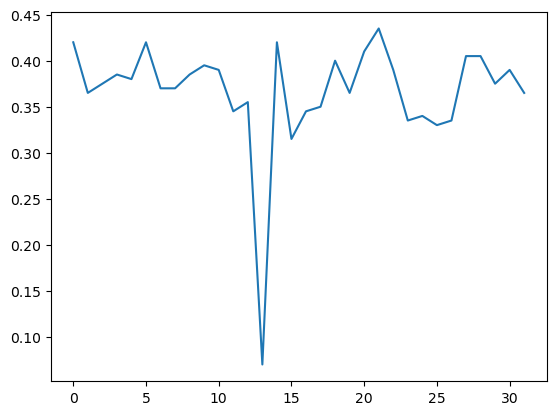

In [ ]:
plt.plot(sampler.acceptance_fraction)

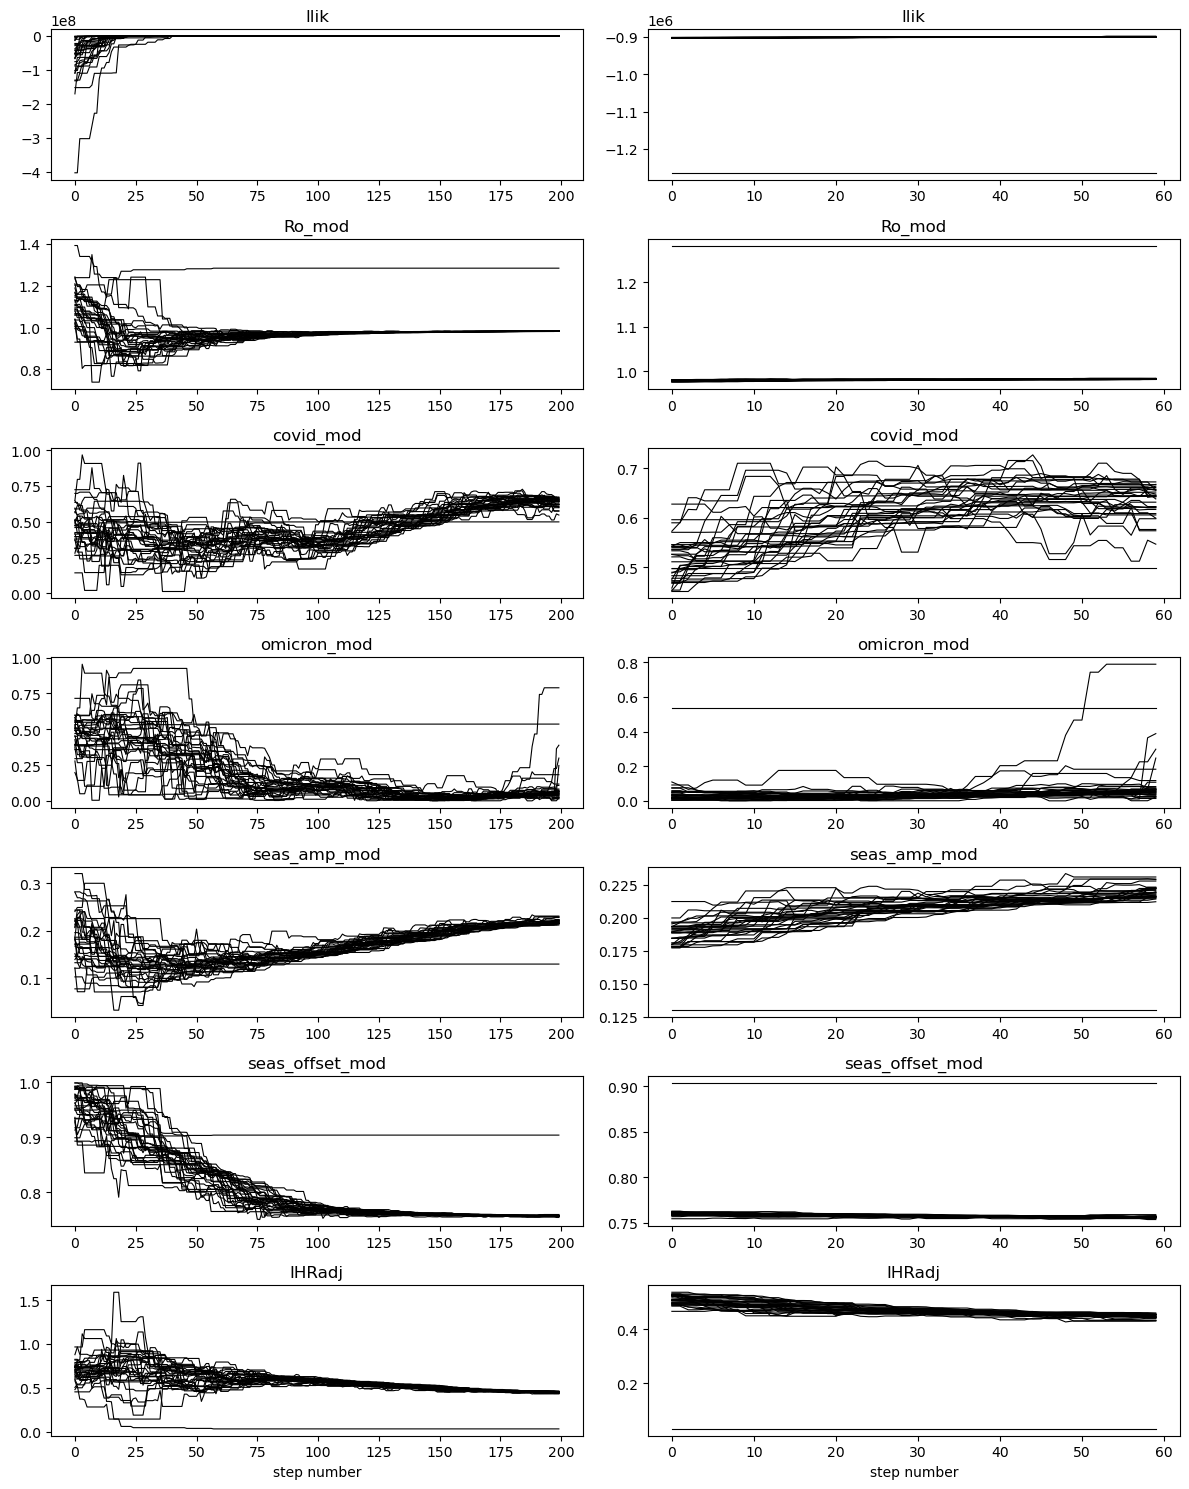

In [ ]:
fig, axes = plt.subplots(ndim+1,2, figsize=(12, 15))
samples = sampler.get_chain()
labels = fitted_params["pname"]


def plot_chain(frompt,axes):
    ax = axes[0]
    ax.plot(sampler.get_log_prob()[frompt:], "k", alpha=1, lw=.8)
    ax.set_title("llik")
    #ax.set_xlim(0, len(samples))

    for i in range(ndim):
        ax = axes[i+1]
        ax.plot(samples[frompt:, :, i], "black", alpha=1, lw=.8,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(140,axes[:,1])
fig.tight_layout()

(-1500000.0, -890000.0)

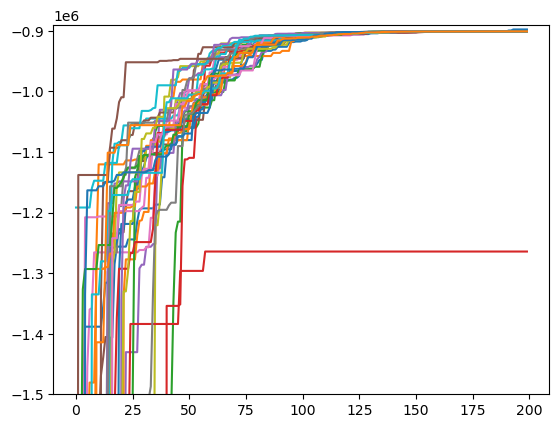

In [ ]:
plt.plot(sampler.get_log_prob());
plt.ylim(-0.15e7,-.089e7)

In [ ]:
samples.shape

In [ ]:
def input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim):
    snpi_df_mod = snpi_df_ref.copy(deep=True)
    hnpi_df_mod = hnpi_df_ref.copy(deep=True)

    for i in range(ndim):
        if fitted_params["ptype"][i] == "snpi":
            snpi_df_mod.loc[snpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]
        elif fitted_params["ptype"][i] == "hnpi":
            hnpi_df_mod.loc[hnpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]

    return snpi_df_mod, hnpi_df_mod


In [ ]:
samples.shape

In [ ]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
13819it [00:22, 623.43it/s]
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.02it/s]
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
13819it [00:20, 667.04it/s]
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.44it/s]
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.88it/s]
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 647.86it/s]
INFO:root:[SEIR.NPI] complet

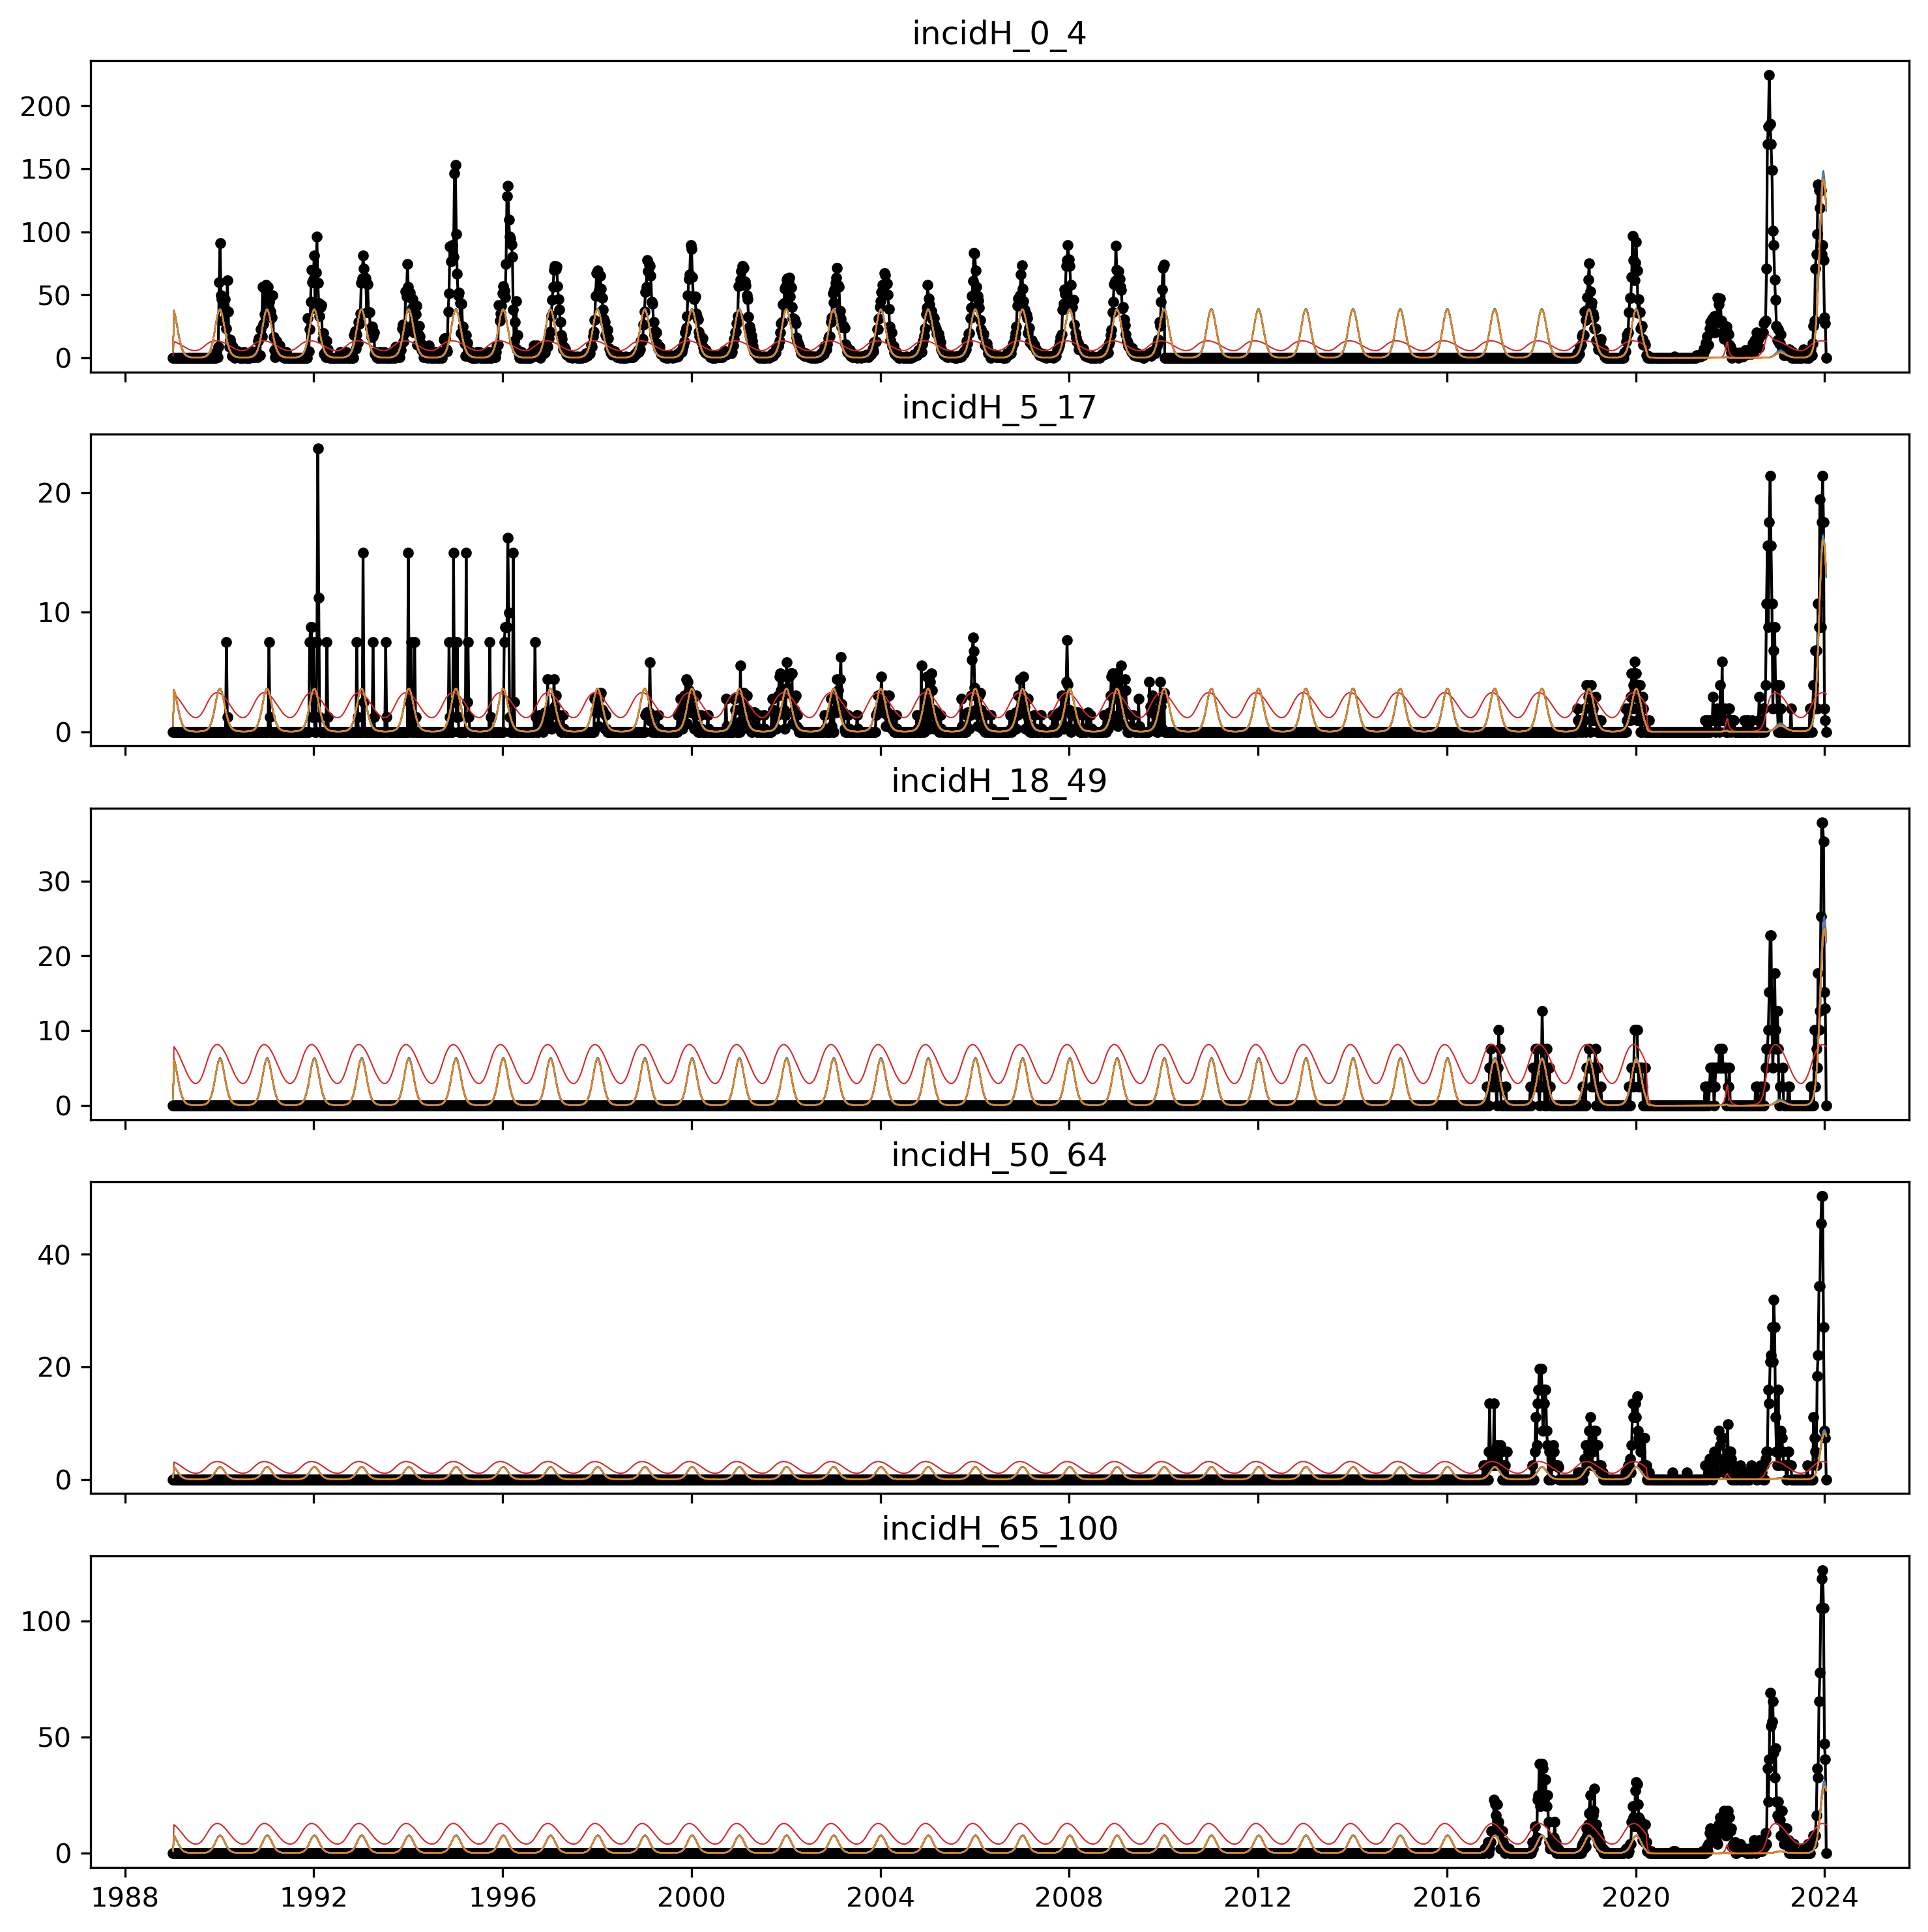

In [ ]:
fig, axes = plt.subplots(len(statistics), figsize=(12, 12), sharex=True, dpi=300)
for subpop in modinf.subpop_struct.subpop_names:
        gt_s = gt[gt["subpop"]==subpop].loc[modinf.ti:modinf.tf].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes.flat[i]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(value)

In [ ]:
import corner

(1600, 6)


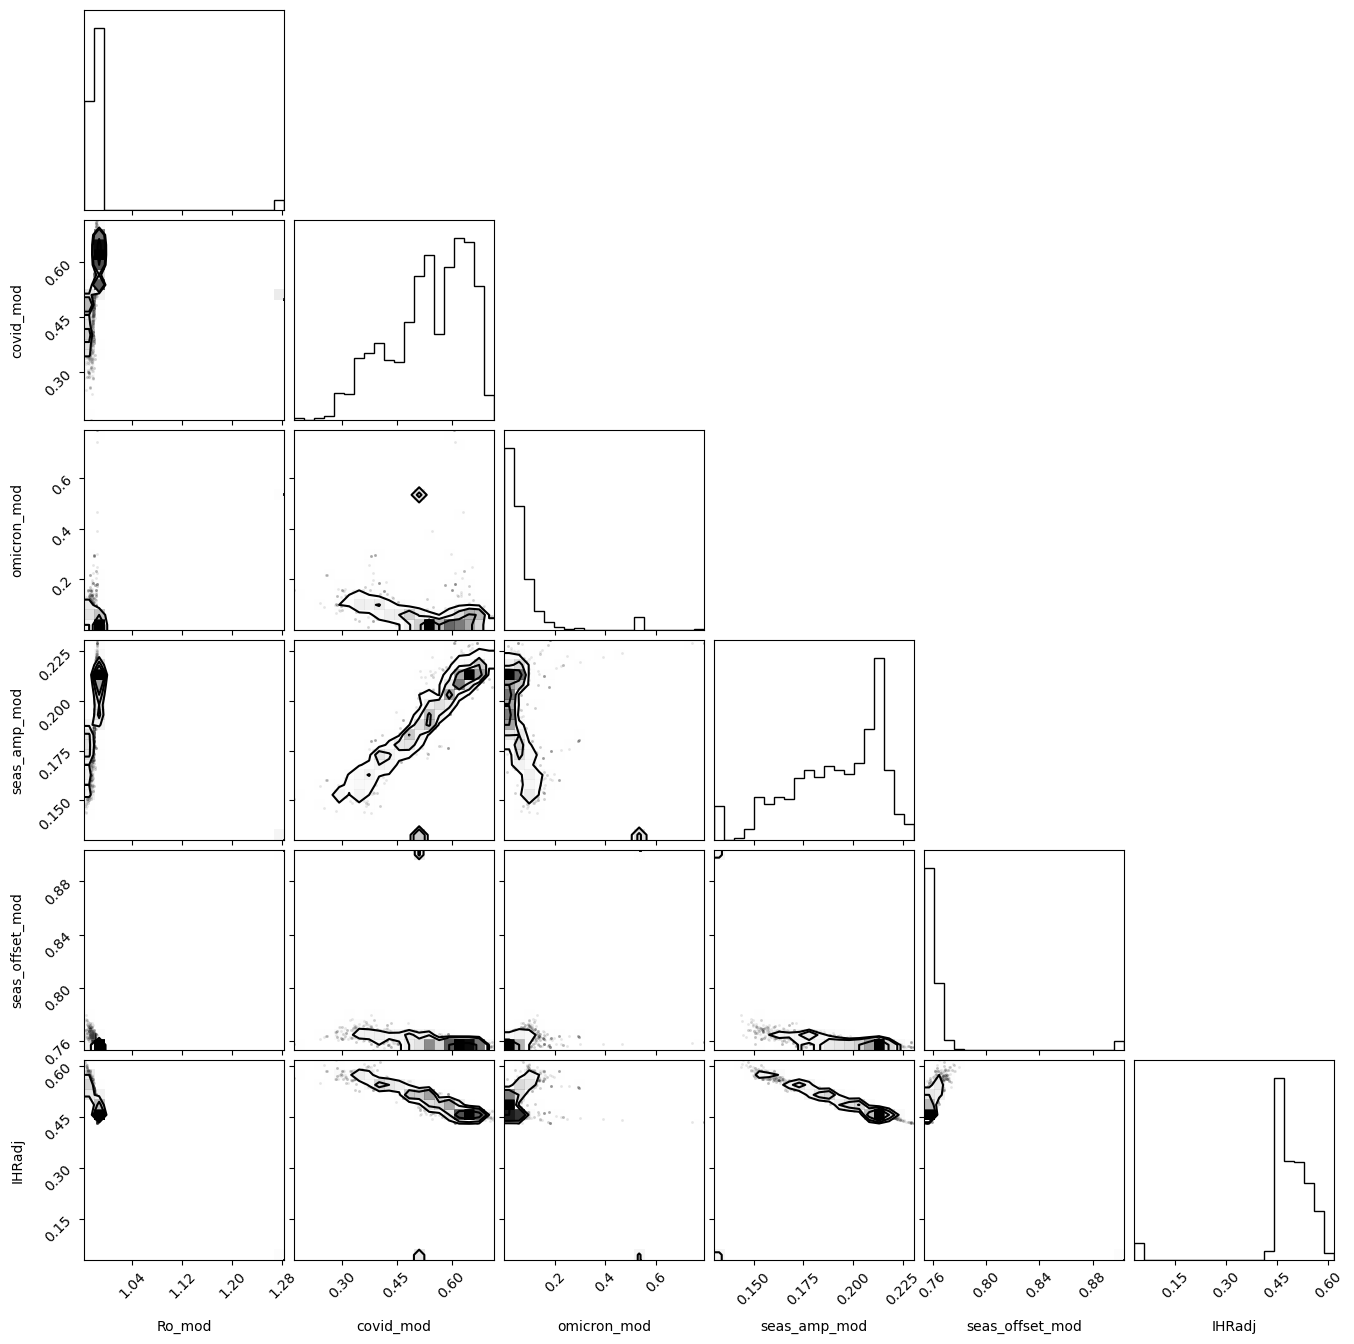

In [ ]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=100, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);